In [1]:
# %pip install antspyx nilearn

In [2]:
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
project_dir = "../braintypicality"
sys.path.append(project_dir)

In [3]:
import re
import functools
import glob
import math
import ants
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from functools import partial
from nilearn import datasets, plotting
import os 

/ASD2/emre_projects/miniconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
CACHE_DIR = "../braintypicality/dataset/template_cache/"

procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"

if not os.path.exists(procd_ref_img_path):
    T1_REF_IMG_PATH = os.path.join(
        CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a.nrrd"
    )
    T2_REF_IMG_PATH = os.path.join(
        CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t2_tal_nlin_sym_09a.nrrd"
    )
    MASK_REF_IMG_PATH = os.path.join(
        CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a_mask.nrrd"
    )

    ants_mni = ants.image_read(f"{CACHE_DIR}/croppedMni152.nii.gz")
    t1_ref_img = ants.image_read(T1_REF_IMG_PATH)
    t2_ref_img = ants.image_read(T2_REF_IMG_PATH)
    ref_img_mask = ants.image_read(MASK_REF_IMG_PATH)

    # Use ANTs' tighter cropping
    diff = np.array(t1_ref_img.shape) - np.array(ants_mni.shape)
    crop_idxs_start, crop_idxs_end = 1 + diff // 2, np.array(t1_ref_img.shape) - diff // 2

    t1_ref_img = ants.crop_indices(t1_ref_img, crop_idxs_start, crop_idxs_end)
    t2_ref_img = ants.crop_indices(t2_ref_img, crop_idxs_start, crop_idxs_end)
    ref_img_mask = ants.crop_indices(ref_img_mask, crop_idxs_start, crop_idxs_end)

    procd_ref_img = ants.merge_channels((t1_ref_img * ref_img_mask, t2_ref_img * ref_img_mask))
    procd_ref_img.to_filename(procd_ref_img_path)
    
else:
    procd_ref_img = ants.image_read(procd_ref_img_path)


In [5]:
from sade.configs.flows import ve_flow_config as configs
config = configs.get_config()

transforms_dir = f"/BEE/Connectome/ABCD/Users/emre/braintyp/spacing_2-ants"

def register_to_mni(x:np.ndarray, fname: str, multichannel=False,ref_img_post_transform=None):
    fname =  os.path.basename(fname)
    sampleid = re.match(r"(.*)(\.npz|\.nii.gz)", fname).group(1)
    transform_mat = f"{transforms_dir}/{sampleid}Composite.h5"
    
    if multichannel:
        x = x.transpose(1,2,3,0)
        x = ants.from_numpy(x)

        return ants.apply_transforms(
            fixed=ref_img_post_transform, interpolator="linear", verbose=False,
            moving=x, transformlist=transform_mat, imagetype = 3
        ).numpy().transpose(3,0,1,2)
        
    x = ants.from_numpy(x)
    return ants.apply_transforms(
        fixed=ref_img_post_transform, interpolator="linear", verbose=False,
        moving=x, transformlist=transform_mat
    )

In [6]:
from sade.configs.flows import ve_flow_config as configs
from sade.datasets.loaders import get_image_files_list, get_val_transform, get_lesion_transform
from sade.metrics import erode_brain_masks

ref_img_post_transform_path = f"{CACHE_DIR}/ps2-niral-mni-postproc.nii.gz"

if not os.path.exists(ref_img_post_transform_path):

    config = configs.get_config()
    config.msma.denoise=False
    config.msma.schedule = "geometric"
    config.model.learnable_embedding=True
    workdir = "../braintypicality/workdir/cuda_opt/learnable"
    unscale = lambda x: (x+1)/2

    img_loader = get_val_transform(config)
    img_and_label_loader = get_lesion_transform(config)

    procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"
    ref_img_tensor = img_loader({"image": procd_ref_img_path})["image"].numpy()
    ref_img_post_transform = unscale(ants.from_numpy(ref_img_tensor[0]))

    ref_img_post_transform.to_filename(ref_img_post_transform_path)
else:
    ref_img_post_transform = ants.image_read(ref_img_post_transform_path)

2025-05-30 20:04:04.461184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 20:04:04.475143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 20:04:04.479280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 20:04:04.490209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-30 20:04:07.485266: W tensorflow/compiler/tf2

In [7]:
bmask = (ref_img_post_transform.numpy() > 0).astype(float)
BRAIN_MASK = ants.from_numpy(bmask)
# ERODED_BRAIN_MASK = ants.from_numpy(erode_brain_masks(BRAIN_MASK[None,...].numpy(),radius=2)[0])

In [8]:
workdir = "../braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct/"
dataset_abcd_asd = "abcd-asd"
dataset_val = "abcd-val"
dataset_test = "abcd-test"
fnames_abcd_asd = glob.glob(f"{workdir}/{dataset_abcd_asd}/*")
fnames_val = glob.glob(f"{workdir}/{dataset_val}/*")
fnames_test = glob.glob(f"{workdir}/{dataset_test}/*")
print(fnames_abcd_asd[0], "\n", fnames_val[0], "\n", fnames_test[0])



../braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct//abcd-asd/NDARINV0182J779.npz 
 ../braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct//abcd-val/HCD0111716.npz 
 ../braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct//abcd-test/HCD0059235.npz


In [9]:
fnames_val = fnames_val + fnames_test


In [10]:
list_val_unprocessed_t1 = []
list_val_unprocessed_t2 = []
list_val_processed = []
list_val_original = []
list_val_registered_original = []
list_val_heatmap = []
list_val_registered_heatmap = []
list_val_sid = []

for f in tqdm(fnames_val):
    sid = re.match(r".*\/(.*)(\.npz|\.nii.gz)", f).group(1)
    # sid = sid.split("/")[0]
    if sid[0]=="N":
        unprocessed_t1 = ants.image_read(f"/BEE/Connectome/ABCD/ImageData/Data/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T1w.nii.gz")
        unprocessed_t2 = ants.image_read(f"/BEE/Connectome/ABCD/ImageData/Data/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T2w.nii.gz")
    else:
        unprocessed_t1 = []
        unprocessed_t2 = []
    processed = ants.image_read(f"/BEE/Connectome/ABCD/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz")

    data = np.load(f)
    original = data['original']
    heatmap = data['heatmap']

    registered_original = ants.image_read(f"../braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct/registered-originals-val-test/{sid}.nii.gz")
    registered_hm = ants.image_read(f"../braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct/registered-heatmaps-val-test/{sid}.nii.gz")

    list_val_unprocessed_t1.append(unprocessed_t1)
    list_val_unprocessed_t2.append(unprocessed_t2)
    list_val_processed.append(processed)
    list_val_original.append(original)
    list_val_registered_original.append(registered_original)
    list_val_heatmap.append(heatmap)
    list_val_registered_heatmap.append(registered_hm)
    list_val_sid.append(sid)
    # regx = regx * BRAIN_MASK


  1%|          | 3/330 [00:01<03:08,  1.73it/s]

100%|██████████| 330/330 [07:47<00:00,  1.42s/it]


In [11]:
list_asd_unprocessed_t1 = []
list_asd_unprocessed_t2 = []
list_asd_processed = []
list_asd_original = []
list_asd_registered_original = []
list_asd_heatmap = []
list_asd_registered_heatmap = []
list_asd_sid = []

for f in tqdm(fnames_abcd_asd):
    sid = re.match(r".*\/(.*)(\.npz|\.nii.gz)", f).group(1)
    # sid = sid.split("/")[0]
    unprocessed_t1 = ants.image_read(f"/BEE/Connectome/ABCD/ImageData/Data_abcd_asd_scr_pos_gz/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T1w.nii.gz")
    unprocessed_t2 = ants.image_read(f"/BEE/Connectome/ABCD/ImageData/Data_abcd_asd_scr_pos_gz/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T2w.nii.gz")

    processed = ants.image_read(f"/BEE/Connectome/ABCD/Users/emre/braintyp/processed_v3/{sid}.nii.gz")

    data = np.load(f)
    original = data['original']
    heatmap = data['heatmap']

    registered_original = ants.image_read(f"../braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct/registered-originals-abcd-asd/{sid}.nii.gz")
    registered_hm = ants.image_read(f"../braintypicality/workdir/cuda_opt/learnable/experiments/reprod-correct/registered-heatmaps-abcd-asd/{sid}.nii.gz")

    list_asd_unprocessed_t1.append(unprocessed_t1)
    list_asd_unprocessed_t2.append(unprocessed_t2)
    list_asd_processed.append(processed)
    list_asd_original.append(original)
    list_asd_registered_original.append(registered_original)
    list_asd_heatmap.append(heatmap)
    list_asd_registered_heatmap.append(registered_hm)
    list_asd_sid.append(sid)
    # regx = regx * BRAIN_MASK


100%|██████████| 161/161 [04:37<00:00,  1.72s/it]


In [12]:
list_asd_registered_heatmap[0]

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

### Histogram of the heatmaps

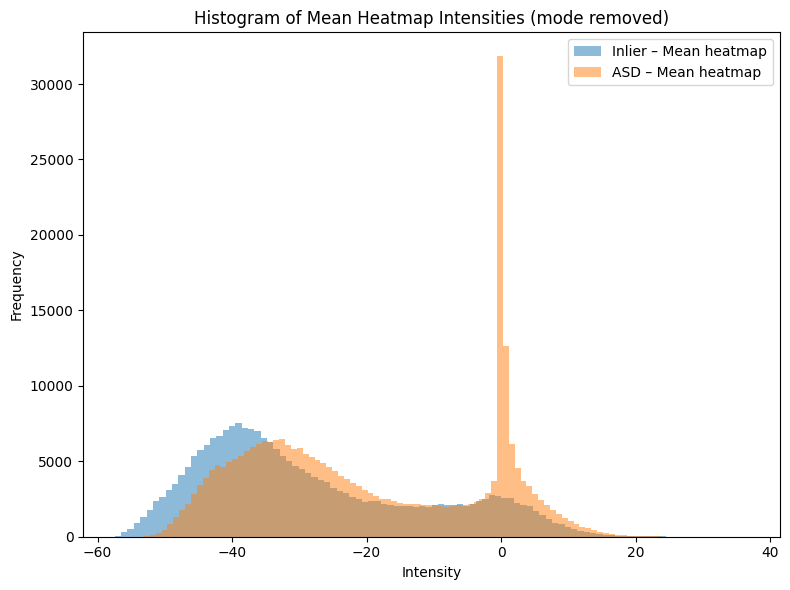

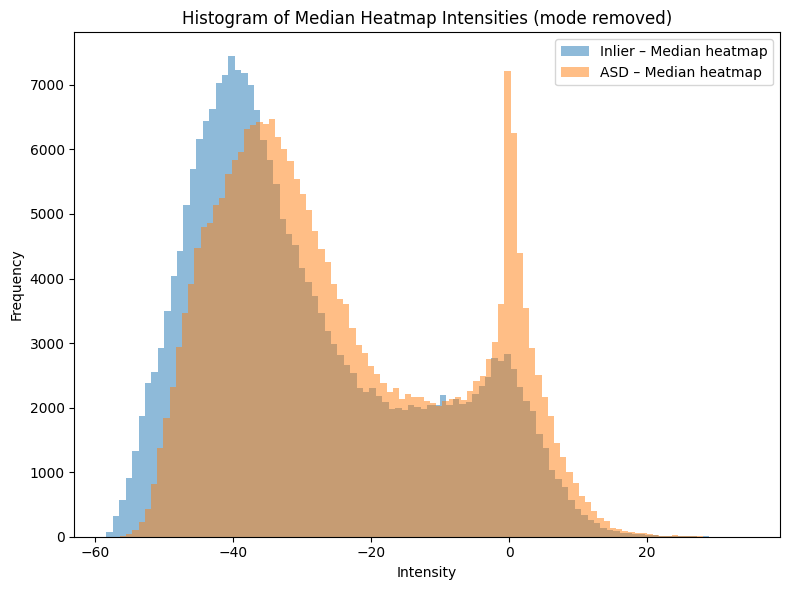

In [13]:
def compute_stat_array(image_list, stat='mean'):
    """
    Given a list of ANTsImage, return a 3D numpy array representing
    the voxelwise mean or median across the list.
    """
    arrays = [img.numpy() for img in image_list]
    stack  = np.stack(arrays, axis=0)  # shape: (n_samples, x, y, z)
    
    if stat == 'mean':
        return np.mean(stack, axis=0)
    elif stat == 'median':
        return np.median(stack, axis=0)
    else:
        raise ValueError("stat must be 'mean' or 'median'")

def mask_out_mode(arr):
    """
    Return 1D flattened data with the single most frequent value removed.
    """
    flat = arr.ravel()
    vals, counts = np.unique(flat, return_counts=True)
    mode_val = vals[np.argmax(counts)]
    return flat[flat != mode_val]

# --- compute mean and median images for each class ---
mean_val   = compute_stat_array(list_val_registered_heatmap,   'mean')
mean_asd   = compute_stat_array(list_asd_registered_heatmap,   'mean')
median_val = compute_stat_array(list_val_registered_heatmap, 'median')
median_asd = compute_stat_array(list_asd_registered_heatmap, 'median')

# --- plot histograms overlayed with semi-transparent bins,
#     excluding the mode of each image ---
def plot_histograms_no_bg(arr1, arr2, label1, label2, title, bins=100):
    data1 = mask_out_mode(arr1)
    data2 = mask_out_mode(arr2)
    
    plt.figure(figsize=(8,6))
    plt.hist(data1, bins=bins, alpha=0.5, label=label1)
    plt.hist(data2, bins=bins, alpha=0.5, label=label2)
    plt.title(title)
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 1) Mean images without their background mode
plot_histograms_no_bg(
    mean_val, mean_asd,
    label1='Inlier – Mean heatmap', 
    label2='ASD – Mean heatmap',
    title='Histogram of Mean Heatmap Intensities (mode removed)'
)

# 2) Median images without their background mode
plot_histograms_no_bg(
    median_val, median_asd,
    label1='Inlier – Median heatmap', 
    label2='ASD – Median heatmap',
    title='Histogram of Median Heatmap Intensities (mode removed)'
)

In [14]:
def normalize_np_image(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())


# def normalize_ants_image(img):
#     # 2. Pull into a NumPy array
#     arr = ants.from_image(img).astype(np.float32)

#     # 3. Min–max scale
#     arr_min, arr_max = arr.min(), arr.max()
#     arr_norm = (arr - arr_min) / (arr_max - arr_min)

#     # 4. Wrap back into an ANTsImage, reusing original geometry
#     return ants.from_numpy(
#         arr_norm,
#         spacing=img.spacing,
#         origin=img.origin,
#         direction=img.direction
#     )


def normalize_ants_image(image):

    channels = ants.split_channels(image) 
    scalar_imgs = [ants.from_numpy(normalize_np_image(channels[c].numpy())) for c in range(len(channels))]
    return ants.merge_channels(scalar_imgs)
    

def plot_3d(image, axis=0, nslices=6, cmap="Greys_r", title=None, t1=True, t2=False, normalize_ants=False):

    if type(image) == np.ndarray and image.ndim == 4:

        scalar_imgs = [ants.from_numpy(normalize_np_image(image[c])) for c in range(image.shape[0])]
        image = ants.merge_channels(scalar_imgs)
    elif type(image) == np.ndarray and image.ndim == 3:
          image = ants.from_numpy(normalize_np_image(image))  
    else:
        image = normalize_ants_image(image) if normalize_ants==True else image

    if image.components == 2:
        channels = ants.split_channels(image)
        #print("channels") 
        #print(channels[0].shape), print(channels[1].shape)
    else:
        channels = [image]

    #print(image.shape), print(type(image)), print(image.components), print(len(channels))
    # Plot channel 0 (e.g. your T1)
    if t1:
        ants.plot(
            channels[0],
            axis=axis,
            nslices=nslices,
            bg_thresh_quant=0.0,
            cmap=cmap,
            title=f" {title} T1" if t2 else title,
            figsize=1.5,
            title_fontsize = 12,
            title_dy=-0.14
        )

    if t2:
        ants.plot(
            channels[1],
            axis=axis,
            nslices=nslices,
            cmap=cmap,
            title=f" {title} T2",
            figsize=1.5,
            title_fontsize = 12,
            title_dy=-0.14
        )

In [15]:
img_idx = 114
ex_unprocessed_t1_asd = list_asd_unprocessed_t1[img_idx]
ex_unprocessed_t2_asd = list_asd_unprocessed_t2[img_idx]
ex_processed_asd = list_asd_processed[img_idx]
ex_or_asd = list_asd_original[img_idx]
ex_registered_asd = list_asd_registered_original[img_idx]
ex_hm_asd = list_asd_heatmap[img_idx]
ex_registered_hm_asd = list_asd_registered_heatmap[img_idx]
ex_sid_asd = list_asd_sid[img_idx]


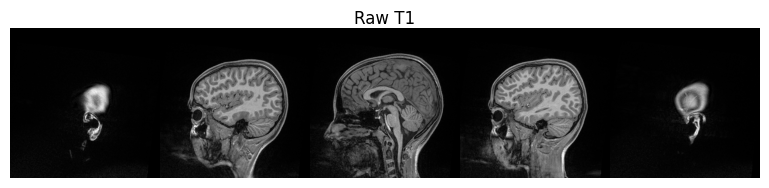

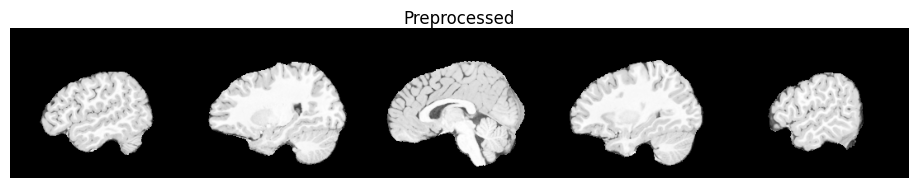

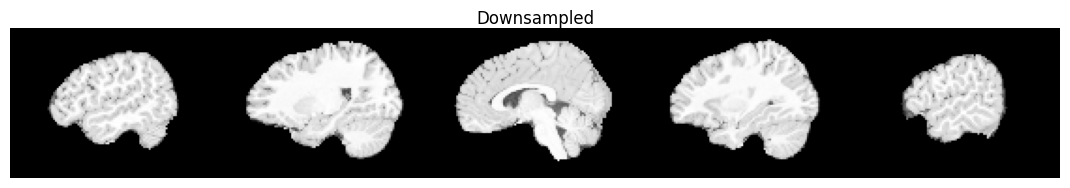

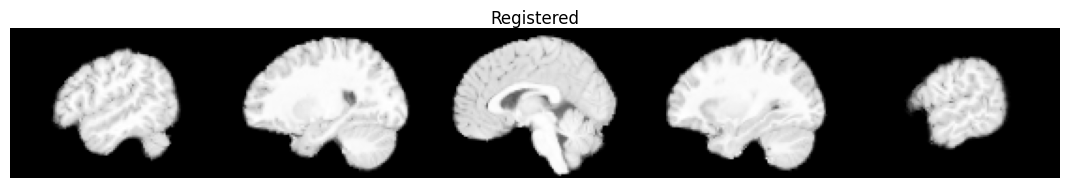

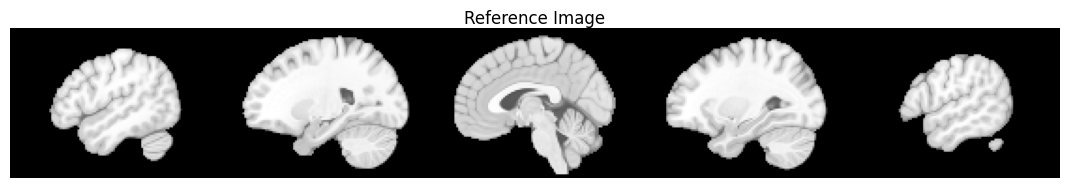

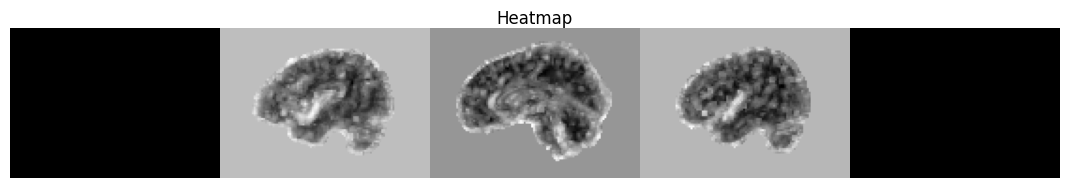

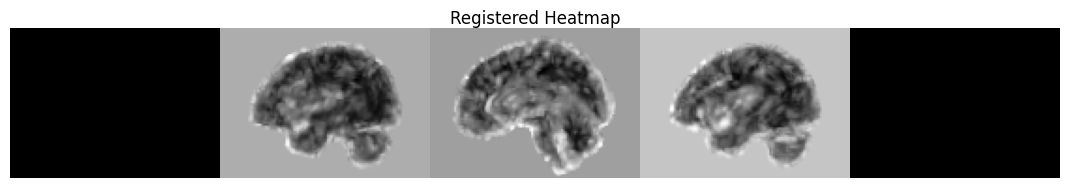

In [16]:
plot_3d(ex_unprocessed_t1_asd,t1=True, t2=False, nslices=5, axis=0, cmap="Greys_r", title="Raw T1")
#plot_3d(ex_unprocessed_t2_asd,t1=True, t2=False, nslices=5, axis=0, cmap="Greys_r", title="Raw T2")
plot_3d(ex_processed_asd,t1=True, t2=False, nslices=5, axis=0, cmap="Greys_r", title="Preprocessed")
plot_3d(ex_or_asd, t1=True, t2=False, nslices=5, axis=0, cmap="Greys_r", title="Downsampled")
plot_3d(ex_registered_asd, t1=True, t2=False, nslices=5, axis=0, cmap="Greys_r", title="Registered", normalize_ants=True)
plot_3d(ref_img_post_transform.numpy(), t1=True, t2=False, nslices=5, axis=0, cmap="Greys_r", title="Reference Image", normalize_ants=True)
plot_3d(ex_hm_asd, t1=True, t2=False, nslices=5, axis=0, cmap="Greys_r", title="Heatmap")
plot_3d(ex_registered_hm_asd.numpy(), t1=True, t2=False, nslices=5, axis=0, cmap="Greys_r", title="Registered Heatmap", normalize_ants=True)


In [17]:
type(ex_processed_asd)

ants.core.ants_image.ANTsImage

In [18]:
ex_processed_asd.shape

(182, 218, 182)

In [19]:
import ants
import numpy as np

def crop_image_by_percent(img: ants.ANTsImage, percent: float) -> ants.ANTsImage:
    """
    Crop off `percent` (0–1) of each side in each spatial dimension.
    Works for
      • 2D/3D scalar images, and
      • 3D vector fields (stored as 4D with last axis=components).
    """
    if not (0 <= percent < 0.5):
        raise ValueError("percent must be in [0, 0.5).")

    arr = img.numpy()
    spacing = img.spacing
    origin = list(img.origin)
    direction = img.direction

    sd = img.dimension            # number of spatial dims (2 or 3)
    nd = arr.ndim
    comp_dims = nd - sd

    # compute how many voxels to crop on each side
    crop_vox = [int(arr.shape[i] * percent) for i in range(sd)]

    # build slicing tuple: spatial + keep-all for components
    spatial_slices = [
        slice(crop_vox[i], arr.shape[i] - crop_vox[i])
        for i in range(sd)
    ]
    comp_slices = [slice(None)] * comp_dims
    region = tuple(spatial_slices + comp_slices)

    cropped = arr[region]

    # adjust origin in spatial dims
    for i in range(sd):
        origin[i] += spacing[i] * crop_vox[i]

    # if it was a vector field (comp_dims == 1), tell ANTsPy
    if comp_dims == 1:
        # move component axis first, and flag has_components=True
        cropped = np.moveaxis(cropped, -1, 0)
        return cropped

    # otherwise a plain scalar
    return cropped

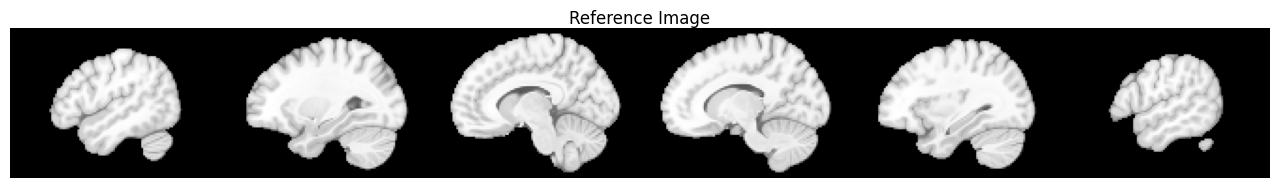

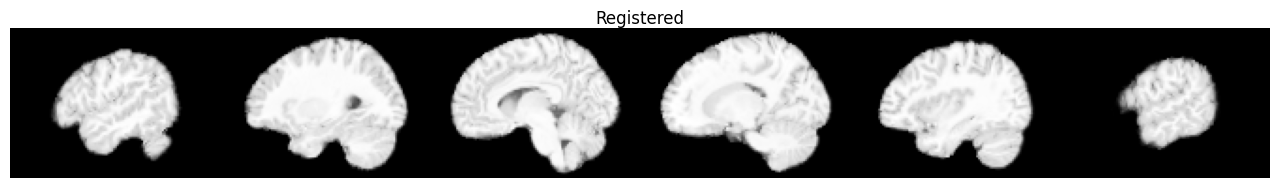

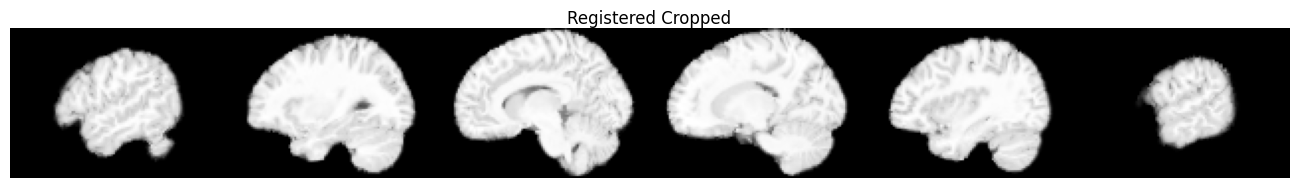

In [20]:
img_idx = 160
nslices = 6
ex_registered_asd = list_asd_registered_original[img_idx]
cropped_img_per = crop_image_by_percent(ex_registered_asd, percent=0.025)
plot_3d(ref_img_post_transform.numpy(), t1=True, t2=False, nslices=nslices, axis=0, cmap="Greys_r", title="Reference Image", normalize_ants=True)
plot_3d(ex_registered_asd, t1=True, t2=False, nslices=nslices, axis=0, cmap="Greys_r", title="Registered", normalize_ants=True)
plot_3d(cropped_img_per, t1=True, t2=False, nslices=nslices, axis=0, cmap="Greys_r", title="Registered Cropped", normalize_ants=True)


In [21]:
list_asd_sid[70]

'NDARINVCCBRA37Z'

In [22]:
type(ex_registered_asd)

ants.core.ants_image.ANTsImage

In [23]:
ex_registered_asd.numpy().max()

1.0

In [24]:
import ants
import numpy as np

def remove_zero_padding(img: ants.ANTsImage) -> ants.ANTsImage:
    """
    Crop out all-zero padding from an ANTsImage. Supports
    - 2D/3D scalar images, and
    - 3D vector images (stored internally as 4D: x,y,z,component).
    """
    arr = (img.numpy() + 1) / 2
    spacing = img.spacing       # e.g. (sx, sy, sz)
    origin = list(img.origin)   # mutable copy
    direction = img.direction

    # number of spatial dims is len(spacing)
    sd = len(spacing)
    nd = arr.ndim
    comp_dims = nd - sd

    # collapse across any extra dims (vector components)
    if comp_dims > 0:
        comp_axes = tuple(range(sd, nd))
        mask = np.any(arr != 0, axis=comp_axes)
    else:
        mask = arr != 0

    if not np.any(mask):
        raise ValueError("Image is entirely zero.")

    # find bounding box in the spatial dims
    nz = np.nonzero(mask)  # tuple of arrays, one per spatial dim
    mins = [int(np.min(v)) for v in nz]
    maxs = [int(np.max(v)) for v in nz]

    # build slices: spatial slices + full for comp dims
    spatial_slices = [slice(lo, hi + 1) for lo, hi in zip(mins, maxs)]
    comp_slices = [slice(None)] * comp_dims
    region = tuple(spatial_slices + comp_slices)

    cropped = arr[region]

    # adjust origin only in the spatial dims
    for i, lo in enumerate(mins):
        origin[i] += spacing[i] * lo

    # if this was a vector image (comp_dims == 1), 
    # ANTs wants numpy shaped (nComp, X, Y, Z) + has_components=True
    if comp_dims == 1:
        # move the single component axis up front
        cropped = np.moveaxis(cropped, -1, 0)
        return cropped * 2 - 1 
        # ants.from_numpy(
        #     cropped,
        #     origin=tuple(origin),
        #     spacing=spacing,
        #     direction=direction,
        #     has_components=True
        # )

    # otherwise a plain scalar image
    return cropped * 2 - 1 
        # ants.from_numpy(
        # cropped,
        # origin=tuple(origin),
        # spacing=spacing,
        # direction=direction
        # )

In [25]:
import ants
import numpy as np

def crop_image_by_percent(img: ants.ANTsImage, percent: float) -> ants.ANTsImage:
    """
    Crop off `percent` (0–1) of each side in each spatial dimension.
    Works for
      • 2D/3D scalar images, and
      • 3D vector fields (stored as 4D with last axis=components).
    """
    if not (0 <= percent < 0.5):
        raise ValueError("percent must be in [0, 0.5).")

    arr = img.numpy()
    spacing = img.spacing
    origin = list(img.origin)
    direction = img.direction

    sd = img.dimension            # number of spatial dims (2 or 3)
    nd = arr.ndim
    comp_dims = nd - sd

    # compute how many voxels to crop on each side
    crop_vox = [int(arr.shape[i] * percent) for i in range(sd)]

    # build slicing tuple: spatial + keep-all for components
    spatial_slices = [
        slice(crop_vox[i], arr.shape[i] - crop_vox[i])
        for i in range(sd)
    ]
    comp_slices = [slice(None)] * comp_dims
    region = tuple(spatial_slices + comp_slices)

    cropped = arr[region]

    # adjust origin in spatial dims
    for i in range(sd):
        origin[i] += spacing[i] * crop_vox[i]

    # if it was a vector field (comp_dims == 1), tell ANTsPy
    if comp_dims == 1:
        # move component axis first, and flag has_components=True
        cropped = np.moveaxis(cropped, -1, 0)
        return cropped

    # otherwise a plain scalar
    return cropped

In [26]:
cropped_img = remove_zero_padding(ex_registered_asd)

In [27]:
# crop 10% off each side:
cropped_img_per = crop_image_by_percent(ex_registered_asd, percent=0.025)

In [29]:
len(list_asd_registered_original)

161

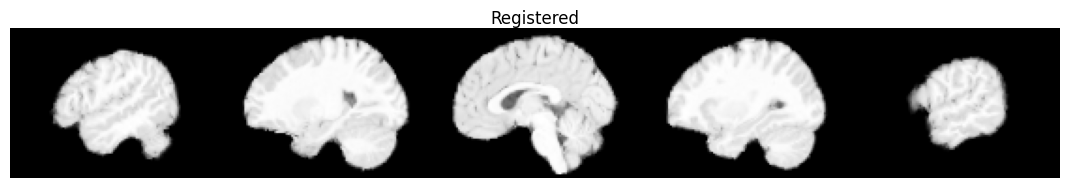

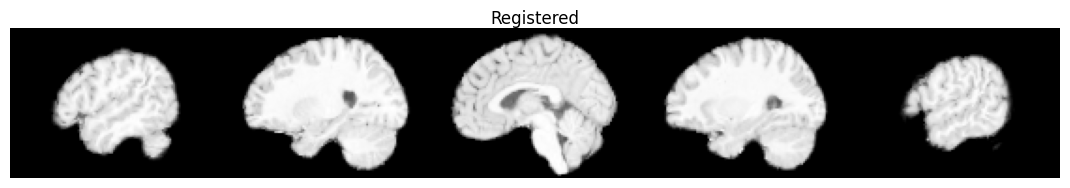

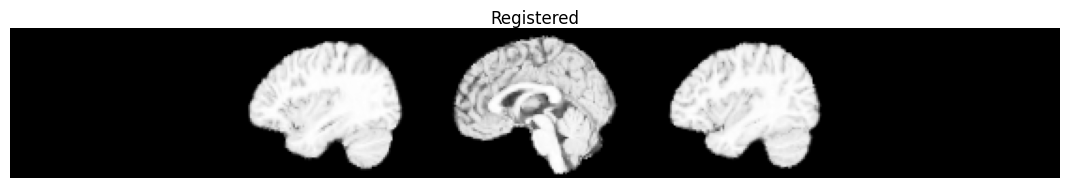

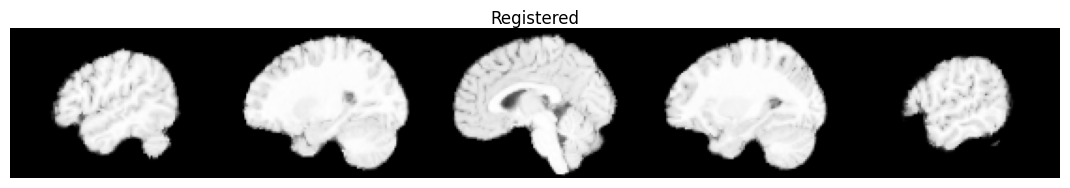

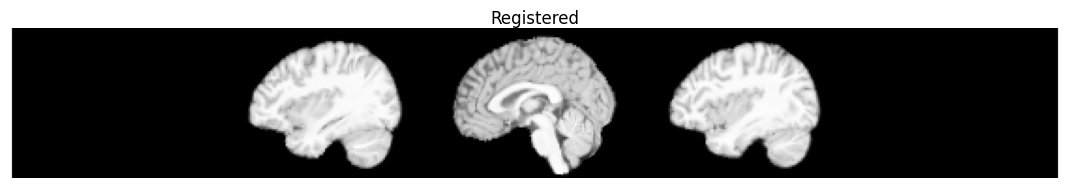

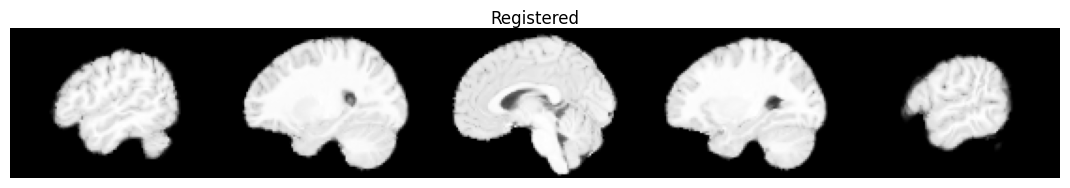

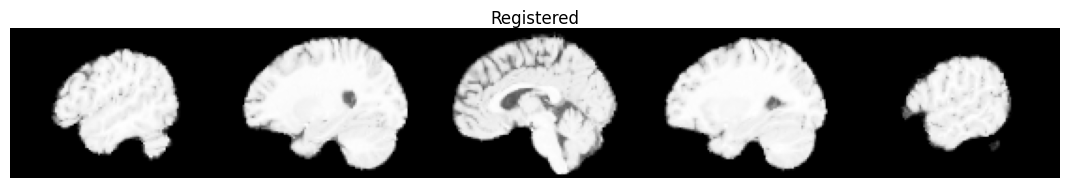

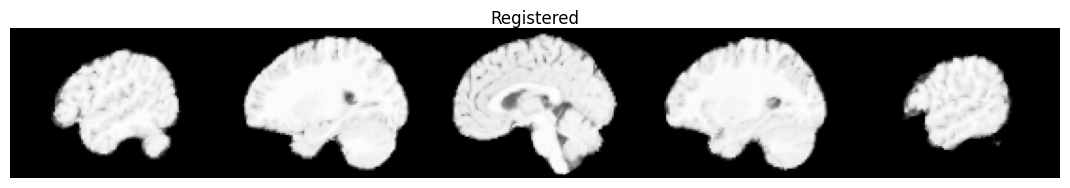

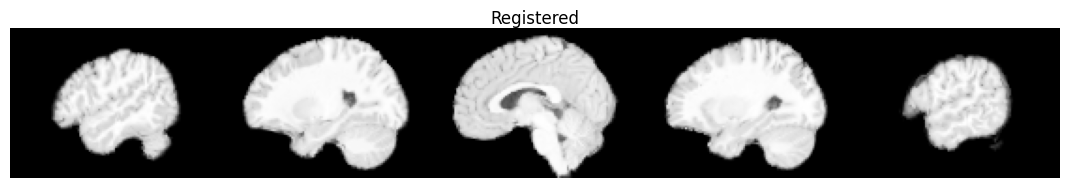

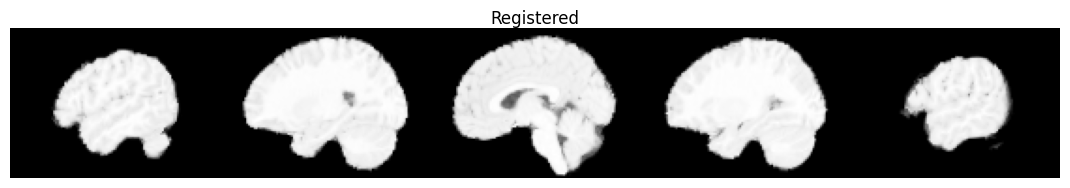

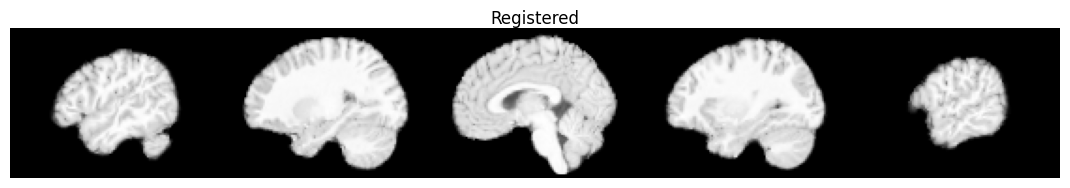

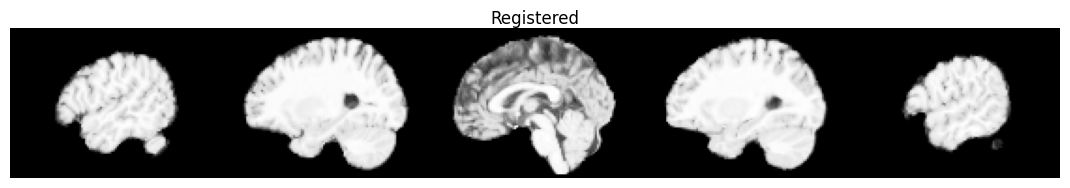

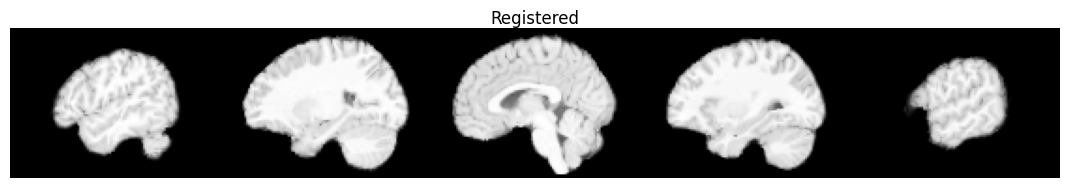

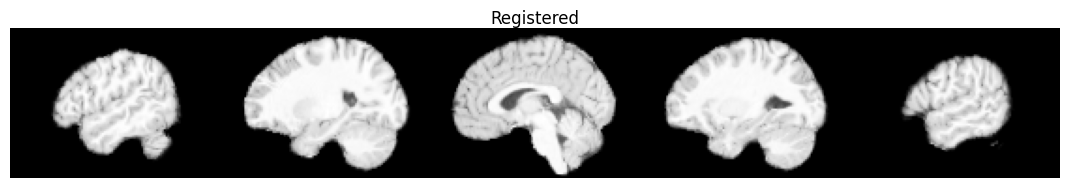

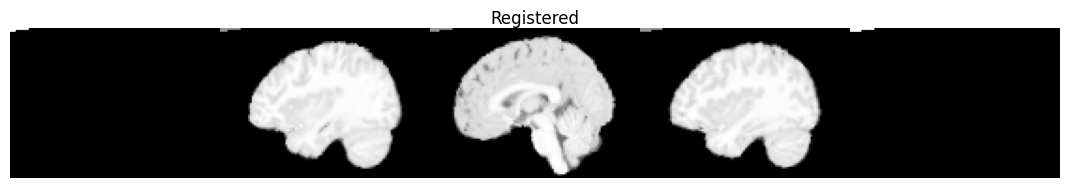

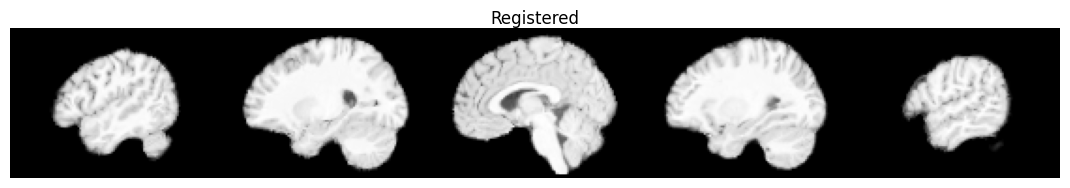

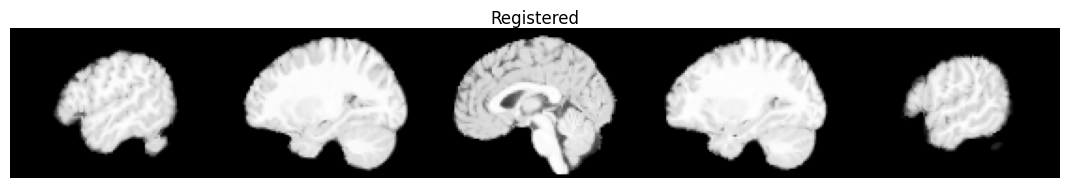

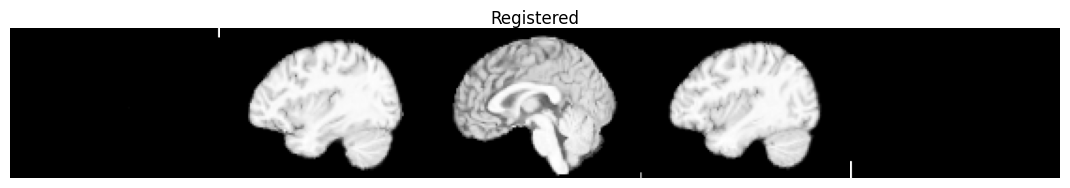

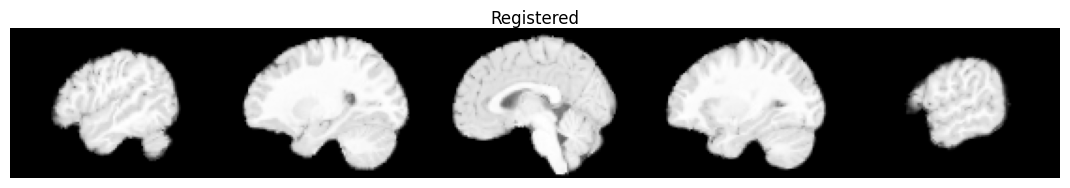

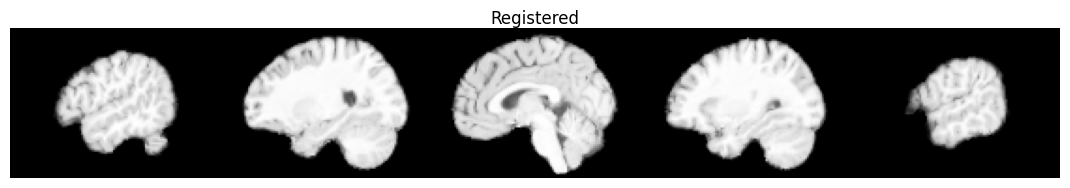

In [30]:
for img_idx in range(20):
    ex_registered_asd = list_asd_registered_original[img_idx]
    plot_3d(ex_registered_asd, t1=True, t2=False, nslices=5, axis=0, cmap="Greys_r", title="Registered", normalize_ants=True)

In [ ]:
import ants
from ants import plot_grid
import numpy as np
from typing import Union, List

def normalize_np(arr: np.ndarray) -> np.ndarray:
    """Min–max normalize a numpy array to [0,1]."""
    arr = arr.astype(np.float32)
    return (arr - arr.min()) / (arr.max() - arr.min())

def to_scalar_ants(
    img: Union[ants.ANTsImage, np.ndarray],
    normalize: bool = True,
    component: int = 0
) -> ants.ANTsImage:
    """
    Convert a (possibly multi-channel) ANTsImage or numpy array into
    a single-channel ANTsImage for plotting.
    """
    # Handle numpy array input
    if isinstance(img, np.ndarray):
        if img.ndim == 4:
            data = img[component]
        elif img.ndim == 3:
            data = img
        else:
            raise ValueError(f"Unsupported numpy array shape {img.shape}")
        if normalize:
            data = normalize_np(data)
        return ants.from_numpy(data)

    # Handle ANTsImage input
    if isinstance(img, ants.ANTsImage):
        if img.components > 1:
            img = ants.split_channels(img)[component]
        if normalize:
            arr = img.numpy()
            arr = normalize_np(arr)
            img = ants.from_numpy(
                arr,
                spacing=img.spacing,
                origin=img.origin,
                direction=img.direction,
            )
        return img

    raise TypeError(f"Unsupported image type: {type(img)}")

def plot_images_row_v2(
    images: List[Union[ants.ANTsImage, np.ndarray]],
    slice_num: int = 6,
    axis: int = 0,
    cmap: str = "Greys_r",
    titles: List[str] = None,
    component: int = 0,
    cpad: float = 0.02,
    rpad: float = 0.02
):
    """
    Plot multiple images side‐by‐side in one row, handling different slice counts.
    
    Args:
        images:     List of ANTsImage or numpy array images.
        slice_idxs: Single int or list of ints for each image. If None, center slice of each.
        axis:       Axis along which to slice (0=sagittal, 1=coronal, 2=axial).
        cmap:       Colormap name.
        titles:     Optional list of titles, one per image.
        component:  Channel index to pick from multi‐channel images.
        cpad, rpad: Padding between columns and rows.
    """
    
    # Convert each input to a single‐channel, normalized ANTsImage
    scalar_imgs = [
        to_scalar_ants(img, normalize=True, component=component)
        for img in images
    ]
    N = len(scalar_imgs)

    for slc in range(slice_num):   
        # Determine one slice index per image
        slice_idxs_list = [(img.shape[axis] // (slice_num+1)) * (slc+1) for img in scalar_imgs]
        
        # Build 1×N grids for images, slices, and axes
        image_grid = [scalar_imgs]
        slice_grid = [slice_idxs_list]
        axis_grid  = [[axis] * N]
        
        # Plot using ANTsPy’s plot_grid
        plot_grid(
            image_grid,
            slice_grid,
            axis_grid,
            cmap=cmap,
            clabels=titles,
            cpad=cpad,
            rpad=rpad
        )

# -----------------------------

sample_idx = 0
batch = [
    list_asd_unprocessed_t1[sample_idx],
    list_asd_unprocessed_t2[sample_idx],
    list_asd_processed[sample_idx],
    list_asd_original[sample_idx],
    list_asd_registered_original[sample_idx],
    list_asd_heatmap[sample_idx],
    list_asd_registered_heatmap[sample_idx]
]
titles = ["Raw T1", "Raw T2", "Processed", "Downsampled", "Reg’d T1", "Heatmap", "Reg’d Heatmap"]


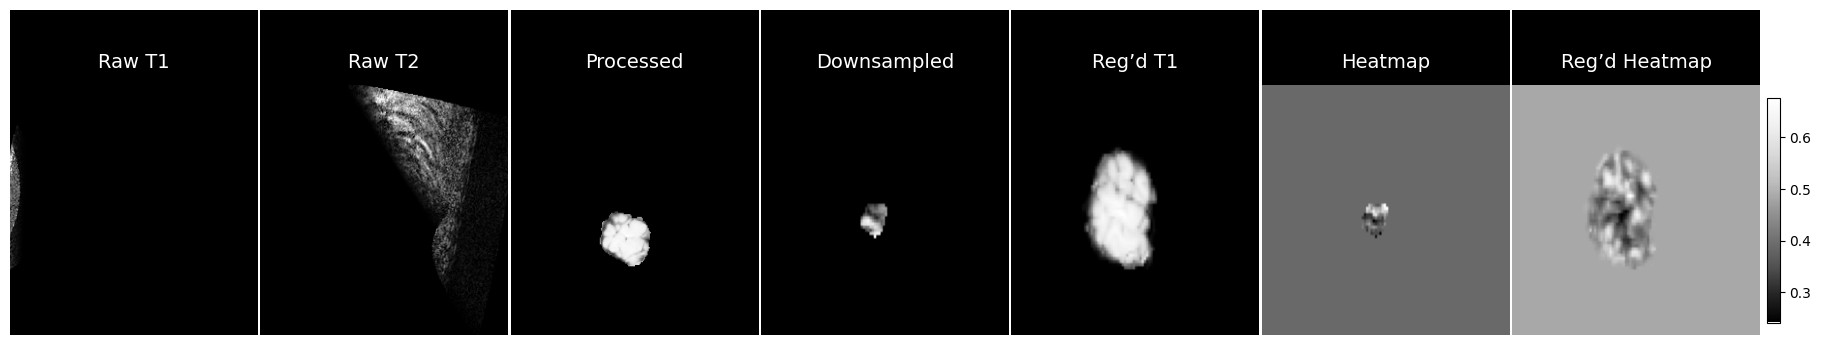

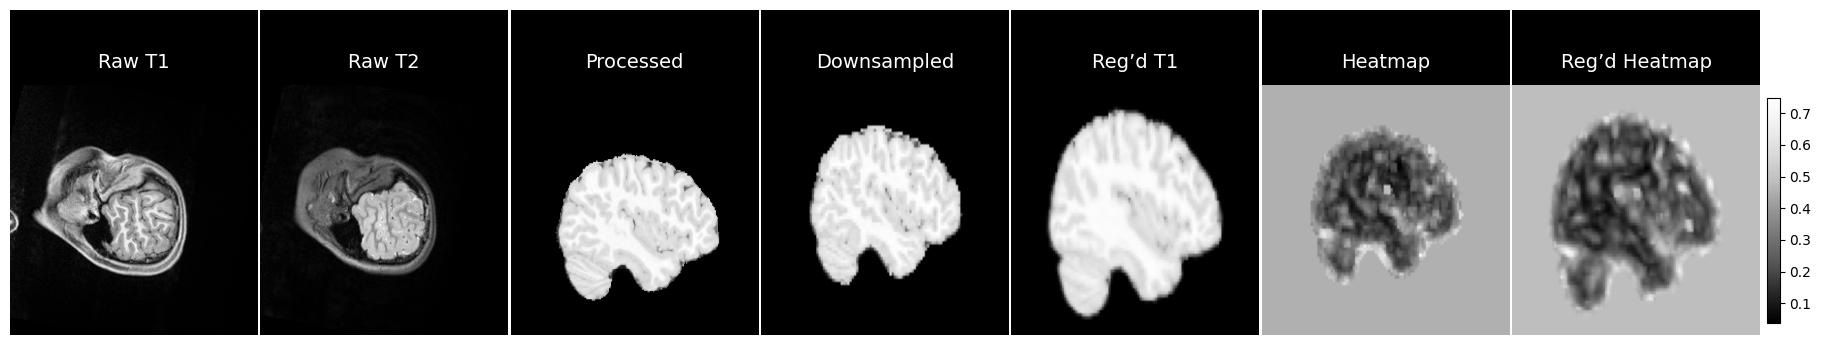

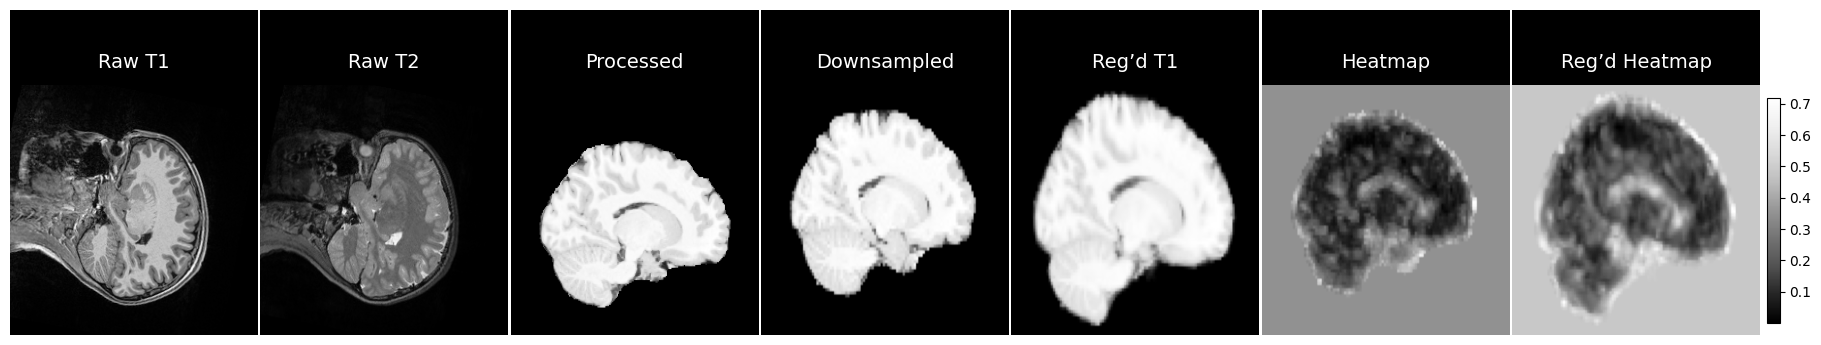

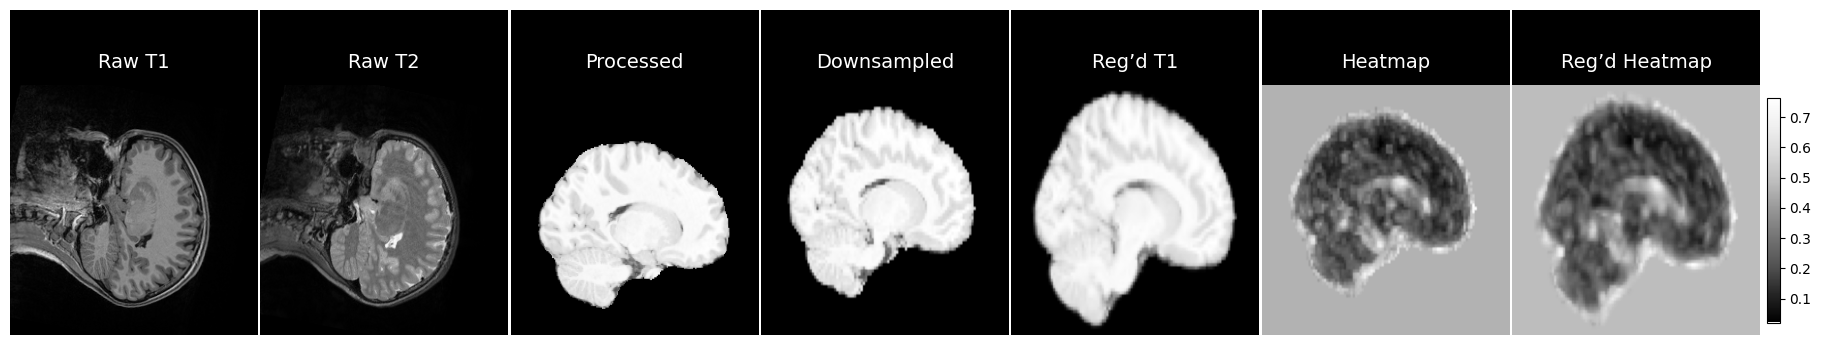

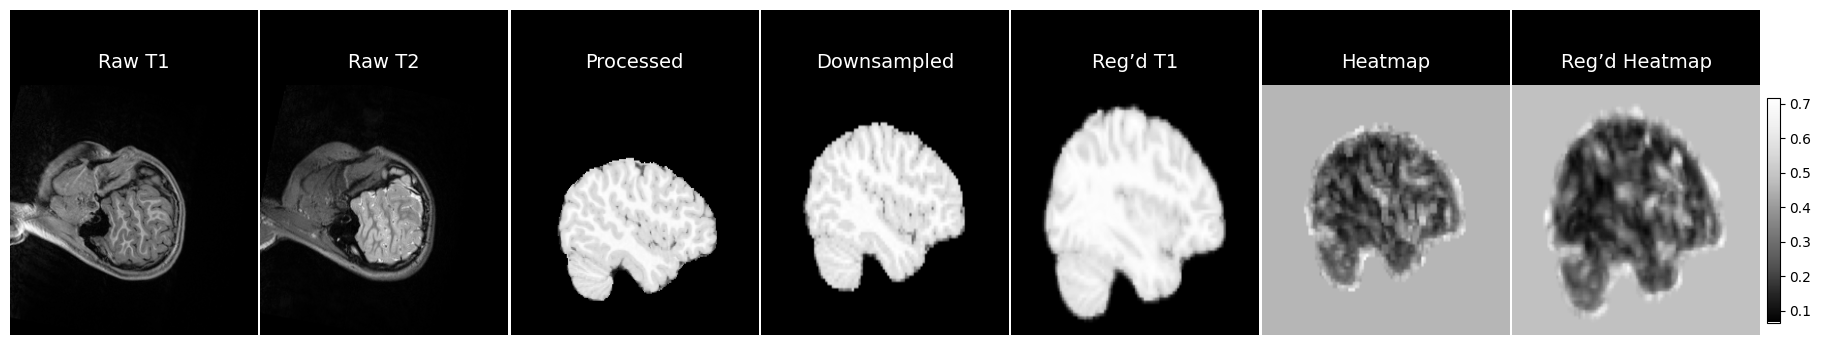

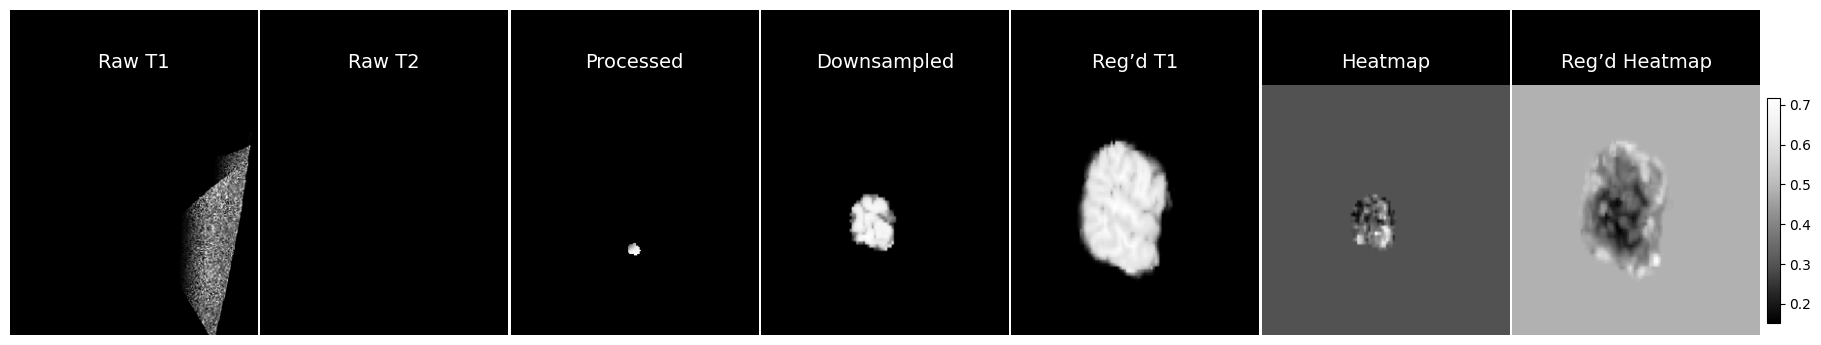

In [32]:
# Plot center slice for each image automatically
plot_images_row_v2(
    images=batch,
    slice_num=6,   # or pass an int or list[int]
    axis=0,
    cmap="Greys_r",
    titles=titles,
    component=0,       # choose which channel if multi-channel
    cpad=0.01,
    rpad=0.01
)